# Overview

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.30:8787/status,
Dashboard: http://10.148.0.30:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.30:39503,Workers: 0
Dashboard: http://10.148.0.30:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [49]:
nc_files = {l: box.load_collocalisations(int(l.split('_')[-1]), drifter=l.split('_')[0], product_type=l.split('_')[1], satellite=l.split('_')[2], ) for l in labels}
nc = nc_files[l][0]
nc1 = nc_files[l][-1]

In [50]:
ds = (xr.open_dataset(nc).chunk(chunks))

In [51]:
ds1 = (xr.open_dataset(nc1).chunk(chunks))

In [52]:
ds

<xarray.Dataset>
Dimensions:                         (obs: 5520, site_obs: 1489, sassa_time: 21)
Coordinates:
    time                            (obs) datetime64[ns] dask.array<chunksize=(1000,), meta=np.ndarray>
    lon                             (obs) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat                             (obs) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
Dimensions without coordinates: obs, site_obs, sassa_time
Data variables: (12/49)
    __site_id                       (obs) object dask.array<chunksize=(1000,), meta=np.ndarray>
    __site_name                     (obs) object dask.array<chunksize=(1000,), meta=np.ndarray>
    gps_drifters_time               (obs, site_obs) datetime64[ns] dask.array<chunksize=(1000, 1489), meta=np.ndarray>
    gps_drifters_rowsize            (obs, site_obs) float64 dask.array<chunksize=(1000, 1489), meta=np.ndarray>
    gps_drifters_WMO                (obs, site_obs) float64 dask.array<chunksize=(1000, 1489), meta=np.ndarray>
    gps_drifters_expno              (obs, site_obs) float64 dask.array<chunksize=(1000, 1489), meta=np.ndarray>
    ...                              ...
    sassa_swh                       (obs, sassa_time) float64 dask.array<chunksize=(1000, 21), meta=np.ndarray>
    sassa_sla_denoised              (obs, sassa_time) float64 dask.array<chunksize=(1000, 21), meta=np.ndarray>
    sassa_miniprod_content_mask     (obs, sassa_time) float32 dask.array<chunksize=(1000, 21), meta=np.ndarray>
    sassa___source_center_index     (obs) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sassa_time_                     (obs, sassa_time) datetime64[ns] dask.array<chunksize=(1000, 21), meta=np.ndarray>
    sassa_lon                       (obs, sassa_time) float64 dask.array<chunksize=(1000, 21), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-SARAL__gps
    __time_coverage_end:    2018-02-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

In [53]:
ds1

<xarray.Dataset>
Dimensions:                         (obs: 6617, site_obs: 1489, sassa_time: 21)
Coordinates:
    time                            (obs) datetime64[ns] dask.array<chunksize=(1000,), meta=np.ndarray>
    lon                             (obs) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat                             (obs) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
Dimensions without coordinates: obs, site_obs, sassa_time
Data variables: (12/49)
    __site_id                       (obs) object dask.array<chunksize=(1000,), meta=np.ndarray>
    __site_name                     (obs) object dask.array<chunksize=(1000,), meta=np.ndarray>
    gps_drifters_time               (obs, site_obs) datetime64[ns] dask.array<chunksize=(1000, 1489), meta=np.ndarray>
    gps_drifters_rowsize            (obs, site_obs) float64 dask.array<chunksize=(1000, 1489), meta=np.ndarray>
    gps_drifters_WMO                (obs, site_obs) float64 dask.array<chunksize=(1000, 1489), meta=np.ndarray>
    gps_drifters_expno              (obs, site_obs) float64 dask.array<chunksize=(1000, 1489), meta=np.ndarray>
    ...                              ...
    sassa_swh                       (obs, sassa_time) float64 dask.array<chunksize=(1000, 21), meta=np.ndarray>
    sassa_sla_denoised              (obs, sassa_time) float64 dask.array<chunksize=(1000, 21), meta=np.ndarray>
    sassa_miniprod_content_mask     (obs, sassa_time) float32 dask.array<chunksize=(1000, 21), meta=np.ndarray>
    sassa___source_center_index     (obs) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sassa_time_                     (obs, sassa_time) datetime64[ns] dask.array<chunksize=(1000, 21), meta=np.ndarray>
    sassa_lon                       (obs, sassa_time) float64 dask.array<chunksize=(1000, 21), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-SARAL__gps
    __time_coverage_end:    2019-01-01T00:00:00
    __time_coverage_start:  2018-12-01T00:00:00

In [172]:
def get_proj(lonc, latc):#converts from lon, lat to native map projection x,y
    """ Create pyproj Proj object, project is an azimutal Eqsuidistant projection centered on the central point of the selected satellite track = matching point
    https://proj.org/operations/projections/aeqd.html
            
    Parameters
    ----------
    lonc,latc : float
        central longitude and latitude of the satellite track, matching point on which the box will be centered
    Return
    ------
    pyproj.Proj object
    """
    return pyproj.Proj(proj="aeqd", lat_0=latc, lon_0=lonc, datum="WGS84", units="m")#aeqd Azimutal EQuiDistant projection centered on lonc,latc

def compute_box_orientation(lonc, latc,lon0, lat0, lon1, lat1):
    """Compute the orientation of the box i.e. the angle (-180 and 180°) between the oriented track (time=0 -> end) and the longitude axe.
        
    Parameters
    ----------
    lonc,latc : float
        central longitude and latitude of the satellite track, matching point on which the box will be centered
    lon1,lat1 : float
        longitude and latitude of the end of the satellite track
    Return
    ------
    box orientation
    """
    proj = get_proj(lonc, latc)
    # get local coordinate
    x0, y0 = proj.transform(lon0, lat0) #xc=yc=0 origin of the box grid
    x1, y1 = proj.transform(lon1, lat1)
    # get orientation of defined by central point and point 1
    #print(lonc,latc,xc,yc,x1,y1)
    phi = np.arctan2( y1-y0, x1-x0 )*180/np.pi # angle (-180 and 180°) between the oriented track (time=0 -> end) and the longitude axe
    #assert  phi==0., (xc,yc, x1,y1)
    #assert False, (lonc, latc)
    #assert False, lon1
    #if lonc == 1.:
        #return 2.
    #else : 
       # return latc
    return phi
    
#compute_box_vec = np.vectorize(compute_box_core)

def compute_box(ds):
    """ Compute box properties around each collocation: 
    central position and orientation
    
    Parameters
    ----------
    ds : xr.DataArray
        colocalisations dataset
    asuff : str
        satellite prefixe

    Return
    ------
    central longitude, central latitude, orientation : xr.Datarray, xr.Datarray, xr.Datarray
    """
    i = (ds["alti_time"].size-1)//2
    lonc = ds["alti_lon"].isel(alti_time=i)
    latc = ds["alti_lat"].isel(alti_time=i)
    #lon1 = ds["alti_lon"].isel(alti_time=-1)
    #lat1 = ds["alti_lat"].isel(alti_time=-1)
    lon = ds["alti_lon"].ffill(dim = 'alti_time').bfill(dim = 'alti_time')
    lat = ds["alti_lat"].ffill(dim = 'alti_time').bfill(dim = 'alti_time')
    lon1 = lon.isel(alti_time=-1)
    lat1 = lat.isel(alti_time=-1)
    lon0 = lon.isel(alti_time=0)
    lat0 = lat.isel(alti_time=0)
    print(lonc.compute(), latc.compute(),lon1.compute(),lat1.compute())
    assert lonc.where(lonc==1., drop=True).size==0, 'dataarray lonc=1'
    
    # will need to vectorize with dask eventually
    phi = xr.apply_ufunc(compute_box_orientation,
                         lonc, latc,
                         lon0, lat0,
                         lon1, lat1,
                         #input_core_dims = [[]]*4,
                         vectorize=True,
                         dask="parallelized",
                        ).rename("phi")

    #phi = compute_box_vec(lonc, latc, lon1, lat1)    

    return lonc, latc, phi

## For file with the issue

l=labels[0]
nc = nc_files[l][0]

In [173]:
chunks=None
if chunks is None:
        chunks = dict(obs=1000)
    #ds = (xr.open_dataset(nc)
ds = (xr.open_dataset(nc).chunk(chunks))
#change prefixes
ds = box.change_prefix(ds)

# add several variables in coords
ds = (ds
        .set_coords(["drifter_"+d for d in ["time", "lon", "lat"]])
        .set_coords(["alti_"+d for d in ["time_", "lon", "lat"]])
    )

#add box 
ds["box_lonc"], ds["box_latc"], ds["box_phi"] = compute_box(ds)
#ds["box_lon"], ds["box_lat"] = compute_box_grid_lonlat(ds, x, y)
#ds["drifter_x"], ds["drifter_y"] = compute_local_xy(ds,'drifter', "site_obs")
#ds = ds.set_coords(["drifter_x", "drifter_y"])
#ds["alti_x"], ds["alti_y"] = compute_local_xy(ds,'alti',"alti_time")
#ds = ds.set_coords(["alti_x", "alti_y"])

<xarray.DataArray 'alti_lon' (obs: 5520)>
array([-127.72167969, -126.79980469, -126.43066406, ...,  -27.28417969,
        -27.76953125,  -27.76464844])
Coordinates:
    time        (obs) datetime64[ns] 2018-01-01T02:00:00 ... 2018-01-24T08:00:00
    lon         (obs) float64 -128.0 -127.2 -126.9 ... -27.95 -27.75 -27.48
    lat         (obs) float64 -30.49 -30.88 -30.64 -29.89 ... 14.69 15.63 15.75
    alti_lat    (obs) float64 -30.57 -30.75 -30.75 -30.01 ... 14.83 15.66 15.7
    alti_time_  (obs) datetime64[ns] 2018-01-01T02:10:33.824673280 ... 2018-0...
    alti_lon    (obs) float64 -127.7 -126.8 -126.4 ... -27.28 -27.77 -27.76
Dimensions without coordinates: obs
Attributes:
    long_name:      Longitude
    units:          degrees
    comment:        negative for degrees west
    axis:           X
    standard_name:  longitude
    valid_range:    [-180.  180.] <xarray.DataArray 'alti_lat' (obs: 5520)>
array([-30.56640625, -30.74511719, -30.75195312, ...,  14.83496094,
        15.659

In [174]:
ds.box_phi.compute()

<xarray.DataArray 'box_phi' (obs: 5520)>
array([-103.2611366 ,  103.29481751, -103.32068657, ...,  102.62547662,
       -102.60960076,  102.65860885])
Coordinates:
    time     (obs) datetime64[ns] 2018-01-01T02:00:00 ... 2018-01-24T08:00:00
    lon      (obs) float64 -128.0 -127.2 -126.9 -125.2 ... -27.95 -27.75 -27.48
    lat      (obs) float64 -30.49 -30.88 -30.64 -29.89 ... 14.69 15.63 15.75
Dimensions without coordinates: obs

In [164]:
ds0 = ds.isel(obs=0).compute()

<xarray.Dataset>
Dimensions:                        (site_obs: 1489, alti_time: 21)
Coordinates:
    time                           datetime64[ns] 2018-01-01T02:00:00
    lon                            float64 -128.0
    lat                            float64 -30.49
    drifter_time                   (site_obs) datetime64[ns] 2017-12-01T02:00...
    drifter_lon                    (site_obs) float64 -125.9 -125.9 ... -125.0
    drifter_lat                    (site_obs) float64 -27.2 -27.2 ... -30.58
    alti_lat                       (alti_time) float64 -29.95 -30.01 ... -31.18
    alti_time_                     (alti_time) datetime64[ns] 2018-01-01T02:1...
    alti_lon                       (alti_time) float64 -127.6 -127.6 ... -127.9
Dimensions without coordinates: site_obs, alti_time
Data variables: (12/46)
    __site_id                      <U6 '132470'
    __site_name                    <U6 '132470'
    drifter_rowsize                (site_obs) float64 2.604e+04 ... 2.604e+04
    drifter_WMO                    (site_obs) float64 5.401e+06 ... 5.401e+06
    drifter_expno                  (site_obs) float64 6.129e+03 ... 6.129e+03
    drifter_deploy_date            (site_obs) datetime64[ns] 2015-05-17 ... 2...
    ...                             ...
    alti_sla_denoised              (alti_time) float64 0.04054 ... 0.04115
    alti_miniprod_content_mask     (alti_time) float32 1.0 1.0 1.0 ... 1.0 1.0
    alti___source_center_index     <U4 '4022'
    box_lonc                       float64 -127.7
    box_latc                       float64 -30.57
    box_phi                        float64 0.0
Attributes:
    __id:                   SASSA-L3-SLA-SARAL__gps
    __time_coverage_end:    2018-02-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

In [165]:
lon

NameError: name 'lon' is not defined

In [ ]:
i = (ds["alti_time"].size-1)//2
lonc = ds["alti_lon"].isel(alti_time=i)
latc = ds["alti_lat"].isel(alti_time=i)
#lon1 = ds["alti_lon"].isel(alti_time=-1)
#lat1 = ds["alti_lat"].isel(alti_time=-1)
lon = ds["alti_lon"].dropna(dim = 'alti_time')
lat = ds["alti_lat"].dropna(dim = 'alti_time')
lon1 = lon.isel(alti_time=-1)
lat1 = lat.isel(alti_time=-1)

In [159]:
phi = ds.box_phi.compute()

In [160]:
phi

<xarray.DataArray 'box_phi' (obs: 5520)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
    time     (obs) datetime64[ns] 2018-01-01T02:00:00 ... 2018-01-24T08:00:00
    lon      (obs) float64 -128.0 -127.2 -126.9 -125.2 ... -27.95 -27.75 -27.48
    lat      (obs) float64 -30.49 -30.88 -30.64 -29.89 ... 14.69 15.63 15.75
Dimensions without coordinates: obs

In [132]:
phi.isel(obs=0)

<xarray.DataArray 'box_phi' ()>
array(-30.56640625)
Coordinates:
    time     datetime64[ns] 2018-01-01T02:00:00
    lon      float64 -128.0
    lat      float64 -30.49

In [128]:
phi.isel(obs=0)

<xarray.DataArray 'box_phi' ()>
array(-127.72167969)
Coordinates:
    time     datetime64[ns] 2018-01-01T02:00:00
    lon      float64 -128.0
    lat      float64 -30.49

In [138]:
proj = get_proj(-127.72167969,-30.56640625,)
xc, yc = proj.transform(-127,-30.56640625,)

In [139]:
xc, yc

(69232.893295458, -221.73403660598643)

In [118]:
phi.where(phi==2, drop=True)

<xarray.DataArray 'box_phi' (obs: 0)>
array([], dtype=float64)
Coordinates:
    time     (obs) datetime64[ns] 
    lon      (obs) float64 
    lat      (obs) float64 
Dimensions without coordinates: obs

In [97]:
ds.where(lonc==1, drop=True).compute()

ValueError: zero-size array to reduction operation minimum which has no identity

In [94]:
lonc.compute()

<xarray.DataArray 'alti_lon' (obs: 5520)>
array([-127.72167969, -126.79980469, -126.43066406, ...,  -27.28417969,
        -27.76953125,  -27.76464844])
Coordinates:
    time        (obs) datetime64[ns] 2018-01-01T02:00:00 ... 2018-01-24T08:00:00
    lon         (obs) float64 -128.0 -127.2 -126.9 ... -27.95 -27.75 -27.48
    lat         (obs) float64 -30.49 -30.88 -30.64 -29.89 ... 14.69 15.63 15.75
    alti_lat    (obs) float64 -30.57 -30.75 -30.75 -30.01 ... 14.83 15.66 15.7
    alti_time_  (obs) datetime64[ns] 2018-01-01T02:10:33.824673280 ... 2018-0...
    alti_lon    (obs) float64 -127.7 -126.8 -126.4 ... -27.28 -27.77 -27.76
Dimensions without coordinates: obs
Attributes:
    long_name:      Longitude
    units:          degrees
    comment:        negative for degrees west
    axis:           X
    standard_name:  longitude
    valid_range:    [-180.  180.]

In [ ]:
box.compute_box(ds)

In [35]:
box_sev = box.compute_box(ds)[2]

In [36]:
box_sev.compute()

<xarray.DataArray 'phi' (obs: 5520)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
    time        (obs) datetime64[ns] 2018-01-01T02:00:00 ... 2018-01-24T08:00:00
    lon         (obs) float64 -128.0 -127.2 -126.9 ... -27.95 -27.75 -27.48
    lat         (obs) float64 -30.49 -30.88 -30.64 -29.89 ... 14.69 15.63 15.75
    alti_lat    (obs) float64 -30.57 -30.75 -30.75 -30.01 ... 14.83 15.66 15.7
    alti_time_  (obs) datetime64[ns] 2018-01-01T02:10:33.824673280 ... 2018-0...
    alti_lon    (obs) float64 -127.7 -126.8 -126.4 ... -27.28 -27.77 -27.76
Dimensions without coordinates: obs

In [39]:
box_one_obs = box.compute_box(ds.isel(obs=10))

In [40]:
box_one_obs[2].values

array(-106.75533618)

## For file without the issue

In [28]:
nc1 = nc_files[l][-1]

In [30]:
chunks=None
if chunks is None:
        chunks = dict(obs=1000)
    #ds = (xr.open_dataset(nc)
ds1 = (xr.open_dataset(nc1).chunk(chunks))
#change prefixes
ds1 = box.change_prefix(ds1)

# add several variables in coords
ds1 = (ds1
        .set_coords(["drifter_"+d for d in ["time", "lon", "lat"]])
        .set_coords(["alti_"+d for d in ["time_", "lon", "lat"]])
    )
#add box 
ds1["box_lonc"], ds1["box_latc"], ds1["box_phi"] = box.compute_box(ds1)
#ds["box_lon"], ds["box_lat"] = compute_box_grid_lonlat(ds, x, y)
#ds["drifter_x"], ds["drifter_y"] = compute_local_xy(ds,'drifter', "site_obs")
#ds = ds.set_coords(["drifter_x", "drifter_y"])
#ds["alti_x"], ds["alti_y"] = compute_local_xy(ds,'alti',"alti_time")
#ds = ds.set_coords(["alti_x", "alti_y"])

In [33]:
box_sev1 = box.compute_box(ds1)[2]

In [34]:
box_sev1

<xarray.DataArray 'phi' (obs: 6617)>
dask.array<transpose, shape=(6617,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>
Coordinates:
    time     (obs) datetime64[ns] dask.array<chunksize=(1000,), meta=np.ndarray>
    lon      (obs) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat      (obs) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
Dimensions without coordinates: obs

In [ ]:
def build_dataset(nc, 
                  x=np.arange(-200e3,200e3,5e3),
                  y = np.arange(-100e3,100e3,5e3),
                  chunks=None,
                  persist=False,
                 ):
    """Build a dataset from data from one .nc file and add the box
    
     Parameters
    ----------
    nc : str
        path to netcdf file to open
    x,y : np.array, np.array
        local coordinates of the box, default is x = np.arange(-200e3,200e3,5e3) and y = np.arange(-100e3,100e3,5e3)
    persist : bool
            True to return ds.persist
    
    Return
    ------
    ds : xr.Datarray
        dataset with data of one .nc file and the local box added
    
    """                  
    if chunks is None:
        chunks = dict(obs=1000)
    #ds = (xr.open_dataset(nc)
    ds = (xr.open_dataset(nc)
          .chunk(chunks)
     )

    #change prefixes
    ds = change_prefix(ds)

    # add several variables in coords
    ds = (ds
          .set_coords(["drifter_"+d for d in ["time", "lon", "lat"]])
          .set_coords(["alti_"+d for d in ["time_", "lon", "lat"]])
         )
    #ds = ds.persist()
    
    #add box 
    ds["box_lonc"], ds["box_latc"], ds["box_phi"] = compute_box(ds)
    ds["box_lon"], ds["box_lat"] = compute_box_grid_lonlat(ds, x, y)
    ds["drifter_x"], ds["drifter_y"] = compute_local_xy(ds,'drifter', "site_obs")
    ds = ds.set_coords(["drifter_x", "drifter_y"])
    ds["alti_x"], ds["alti_y"] = compute_local_xy(ds,'alti',"alti_time")
    ds = ds.set_coords(["alti_x", "alti_y"])
    
    #thetas
    ds["box_theta_lon"],ds["box_theta_lat"] = compute_box_thetas(ds)
    ds['drifter_theta_lon'],ds['drifter_theta_lat']=compute_drifters_thetas(ds)
    
    #project velocities on the local box axes
    ds["drifter_vx"], ds["drifter_vy"] = compute_local_drifters_velocities(ds, "site_obs")
    
    #add along track sla gradients
    
    t = ds["alti_time"]
    tc = (t + t.shift({"alti_time": -1}))*0.5 # C
    tc = tc[:-1].rename({"alti_time": "alti_time_mid"})

    ds = ds.assign_coords(**{"alti_time": t, "alti_time_mid": tc})
    grid = Grid(ds, coords={"t": {"center": "alti_time_mid", "outer": "alti_time"}})

    ds["alti_x_mid"] = grid.interp(ds["alti_x"], axis="t")
    ds["alti_y_mid"] = grid.interp(ds["alti_y"], axis="t")
    ds = ds.set_coords(["alti_x_mid","alti_y_mid"])
    
    #dt = grid.diff(ds[asuff+"_time_"], axis="t")/pd.Timedelta("1S")
    dx = grid.diff(ds["alti_x"], axis="t")
    dy = grid.diff(ds["alti_y"], axis="t")
    dxy = np.sqrt(dx**2+dy**2)

    g = 9.81
    dsla = grid.diff(ds["alti_sla"], axis="t")
    ds["g_grad_sla"] = g*dsla/dxy

    if any(["sla_denoised" in variable for variable in list(ds)]):
        dsla = grid.diff(ds["alti_sla_denoised"], axis="t")
        ds["g_grad_sla_denoised"] = g*dsla/dxy
    else : ds["g_grad_sla_denoised"] = xr.full_like(ds["g_grad_sla"], np.nan)

    # add Coriolis frequency
    ds["f"] = 2 *2*np.pi/86164.1 * np.sin(ds.lat*np.pi/180)
    
    # add momentum conservation equation term
    dt=3600
    ds['acc_x'] = ds.drifter_vx.differentiate("site_obs")/dt
    ds['acc_y'] = ds.drifter_vy.differentiate("site_obs")/dt
    ds['coriolis_x'] = -ds["drifter_vy"]*ds.f
    ds['coriolis_y'] = ds["drifter_vx"]*ds.f
    
    if persist:
        ds = ds.persist()
   
    return ds

______________
# PB box orientation

In [ ]:
ds_pb = DS[labels[0]]

In [44]:
ds_p.box_phi.values

array([   0.        ,    0.        ,    0.        , ...,  105.64054303,
       -105.39881489,  105.54485647])

In [36]:
ds_data = xr.open_zarr(zarr_dir+'/'+labels[0]+'.zarr')
ds_phi0=ds_data.where(ds_data.box_phi>-2, drop=True)
ds_phi0=ds_phi0.where(ds_phi0.box_phi<2, drop=True)


In [45]:
ds_phi1=ds_data.where(ds_data.box_phi<-2, drop=True)

Text(0.5, 1.0, 'phi = -102.5278682824828')

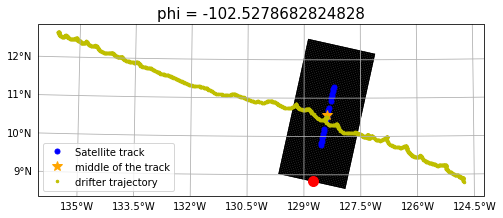

In [48]:
ds1=ds_phi1.isel(obs=1000).compute()
lonc=ds.box_lonc.values
latc=ds.box_latc.values

fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.Orthographic(lonc, latc)), figsize=(8,8))

#_ds = ds.isel(box_x=slice(0,None,10), box_y=slice(0,None,10))
ax.plot(ds.box_lon, ds.box_lat, "-", color="k", transform=crs);
ax.plot(ds.box_lon.T, ds.box_lat.T, "-", color="k", transform=crs);

#Satellite track
ax.plot(ds.alti_lon,ds.alti_lat, "o", ms=5, color="b", transform=crs, label='Satellite track')
#_ds = ds.sel(box_x=0, method="nearest").isel(box_y=-1)
ax.plot(lonc, latc, "*", ms=10, color="orange", transform=crs, label='middle of the track')

#Drifter trajectory
ax.plot(ds.drifter_lon,ds.drifter_lat, ".", ms=5, color="y", transform=crs, label='drifter trajectory')
#_ds = ds.sel(box_x=0, method="nearest").isel(box_y=-1)


_ds = ds.sel(box_y=0, method="nearest").isel(box_x=-1)
ax.plot(_ds.box_lon, _ds.box_lat, "o", ms=10, color="red", transform=crs)


gl = ax.gridlines(draw_labels=True, dms=False, 
                  x_inline=False, y_inline=False, 
                 )

gl.right_labels=False
gl.top_labels=False
plt.legend()
ax.set_title(f'phi = {ds.box_phi.values}', fontsize=15)

Text(0.5, 1.0, 'phi = 0.0')

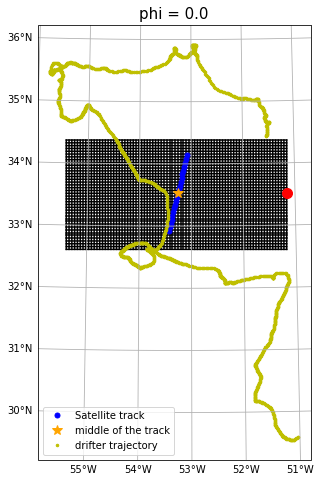

In [49]:
ds=ds_phi0.isel(obs=1000).compute()
lonc=ds.box_lonc.values
latc=ds.box_latc.values

fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.Orthographic(lonc, latc)), figsize=(8,8))

#_ds = ds.isel(box_x=slice(0,None,10), box_y=slice(0,None,10))
ax.plot(ds.box_lon, ds.box_lat, "-", color="k", transform=crs);
ax.plot(ds.box_lon.T, ds.box_lat.T, "-", color="k", transform=crs);

#Satellite track
ax.plot(ds.alti_lon,ds.alti_lat, "o", ms=5, color="b", transform=crs, label='Satellite track')
#_ds = ds.sel(box_x=0, method="nearest").isel(box_y=-1)
ax.plot(lonc, latc, "*", ms=10, color="orange", transform=crs, label='middle of the track')

#Drifter trajectory
ax.plot(ds.drifter_lon,ds.drifter_lat, ".", ms=5, color="y", transform=crs, label='drifter trajectory')
#_ds = ds.sel(box_x=0, method="nearest").isel(box_y=-1)


_ds = ds.sel(box_y=0, method="nearest").isel(box_x=-1)
ax.plot(_ds.box_lon, _ds.box_lat, "o", ms=10, color="red", transform=crs)


gl = ax.gridlines(draw_labels=True, dms=False, 
                  x_inline=False, y_inline=False, 
                 )

gl.right_labels=False
gl.top_labels=False
plt.legend()
ax.set_title(f'phi = {ds.box_phi.values}', fontsize=15)

In [5]:
def get_proj(lonc, latc):#converts from lon, lat to native map projection x,y
    """ Create pyproj Proj object, project is an azimutal Eqsuidistant projection centered on the central point of the selected satellite track = matching point
    https://proj.org/operations/projections/aeqd.html
            
    Parameters
    ----------
    lonc,latc : float
        central longitude and latitude of the satellite track, matching point on which the box will be centered
    Return
    ------
    pyproj.Proj object
    """
    return pyproj.Proj(proj="aeqd", lat_0=latc, lon_0=lonc, datum="WGS84", units="m")#aeqd Azimutal EQuiDistant projection centered on lonc,latc

In [13]:
def compute_box_orientation(lonc, latc, lon1, lat1):
    """Compute the orientation of the box i.e. the angle (-180 and 180°) between the oriented track (time=0 -> end) and the longitude axe.
        
    Parameters
    ----------
    lonc,latc : float
        central longitude and latitude of the satellite track, matching point on which the box will be centered
    lon1,lat1 : float
        longitude and latitude of the end of the satellite track
    Return
    ------
    box orientation
    """
    proj = get_proj(lonc, latc)
    # get local coordinate
    xc, yc = proj.transform(lonc, latc) #xc=yc=0 origin of the box grid
    x1, y1 = proj.transform(lon1, lat1)
    print(f'xc={xc}, yc={yc}, x1={x1},y1={y1}')
    # get orientation of defined by central point and point 1
    #print(lonc,latc,xc,yc,x1,y1)
    phi = np.arctan2( y1-yc, x1-xc )*180/np.pi # angle (-180 and 180°) between the oriented track (time=0 -> end) and the longitude axe
    return phi

In [9]:
def compute_box(ds):
    """ Compute box properties around each collocation: 
    central position and orientation
    
    Parameters
    ----------
    ds : xr.DataArray
        colocalisations dataset
    asuff : str
        satellite prefixe

    Return
    ------
    central longitude, central latitude, orientation : xr.Datarray, xr.Datarray, xr.Datarray
    """
    i = (ds["alti_time"].size-1)//2
    lonc = ds["alti_lon"].isel(alti_time=i)
    latc = ds["alti_lat"].isel(alti_time=i)
    #lon1 = ds["alti_lon"].isel(alti_time=-1)
    #lat1 = ds["alti_lat"].isel(alti_time=-1)
    lon = ds["alti_lon"].dropna(dim = 'alti_time')
    lat = ds["alti_lat"].dropna(dim = 'alti_time')
    lon1 = lon.isel(alti_time=-1)
    lat1 = lat.isel(alti_time=-1)
    print(f'lon1 = {lon1.values}')
    print(f'lat1 = {lat1.values}')
    
    # will need to vectorize with dask eventually
    phi = xr.apply_ufunc(compute_box_orientation,
                         lonc, latc,
                         lon1, lat1,
                         #input_core_dims = [[]]*4,
                         vectorize=True,
                         dask="parallelized",
                        ).rename("phi")

    #phi = compute_box_vec(lonc, latc, lon1, lat1)    

    return lonc, latc, phi

In [19]:
def compute_box_grid_lonlat_core(lonc, latc, phi, x=None, y=None):
    """ Compute coordinates longitude, latitude of the local box grid (x-along satellite track, y-normal to satellite track -> lon,lat)
    https://github.com/rasterio/affine
    
    Parameters
    ----------
    lonc, latc, phi: float  central position and orientation of the box
    x, y: np.array local grid of the box (with origin at (lonc, latc) and x-axis aligned 
    with the satellite track (lonc, latc) - (lon1, lat1) direction)
    
    Return
    ------
    longitude, latitude : np.array, np.array
    
    """
    xv, yv = np.meshgrid(x, y)
    proj = get_proj(lonc, latc)
    #assert False, help(proj.transform)
    xc, yc = proj.transform(lonc, latc)
    # apply inverse affine transformation
    a_fwrd = Affine.translation(-xc, -yc) * Affine.rotation(-phi, pivot=(xc, yc))
    a_back = ~a_fwrd
    #compute coordinates of x,y in the lon, lat orientated grid
    xv_inv, yv_inv = a_back * (xv, yv) 
    lon, lat = proj.transform(xv_inv, yv_inv, 
                              direction=pyproj.enums.TransformDirection.INVERSE,
                             )
    return lon, lat

def compute_box_grid_lonlat(ds, x, y):
    """ Compute local coordinates in longitude, latitude of the local box grid (x-along satellite track, y-normal to satellite track -> lon,lat) for all colocalisations
    
     Parameters
    ----------
    ds : xr.DataArray
        colocalisations dataset 
    x, y: np.array      
        local grid of the box (with origin at (lonc, latc) and x-axis aligned )
    
    Return
    ------
    longitude, latitude : xr.Datarray, xr.Datarray
      
    """
    lon, lat = xr.apply_ufunc(compute_box_grid_lonlat_core,
                   ds.box_lonc, ds.box_latc, ds.box_phi,
                   kwargs=dict(x=x, y=y),
                   output_core_dims = [["box_y", "box_x"]]*2,
                   vectorize=True,
                              dask="parallelized",
                              dask_gufunc_kwargs=dict(output_sizes=dict(box_x=x.size, box_y=y.size)),
                  )
    lon = lon.assign_coords(box_x=x, box_y=y)
    lat = lat.assign_coords(box_x=x, box_y=y)
    return lon, lat

In [16]:
box = compute_box(ds)

lon1 = -53.4326171875
lat1 = 32.916015625
xc=0.0, yc=0.0, x1=-16260.469733295597,y1=-67787.8809433776
xc=0.0, yc=0.0, x1=-16260.469733295597,y1=-67787.8809433776


In [52]:
box[2]

<xarray.DataArray 'phi' ()>
array(-103.48884273)
Coordinates:
    lat      float64 33.74
    lon      float64 -53.92
    time     datetime64[ns] 2018-01-30T22:00:00

In [57]:
x=np.arange(-200e3,200e3,5e3)
y = np.arange(-100e3,100e3,5e3)
comp_box = compute_box_grid_lonlat_core(ds.box_lonc.values, ds.box_latc.values, ds.box_phi, x,y)

__________

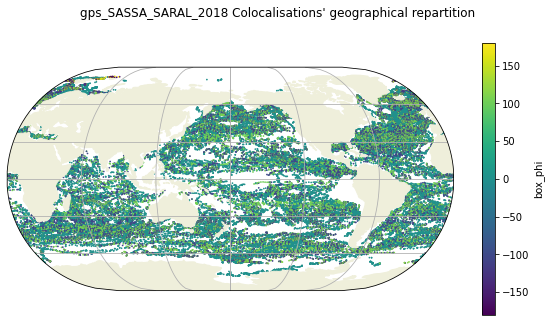

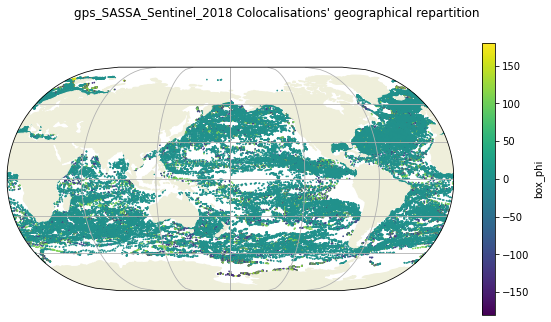

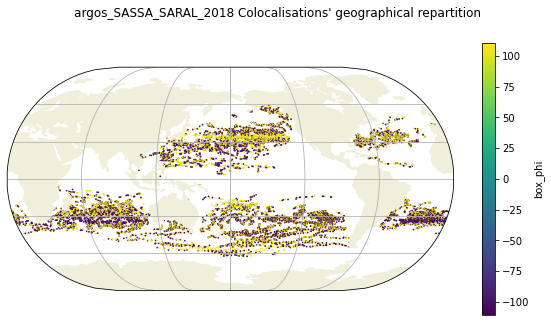

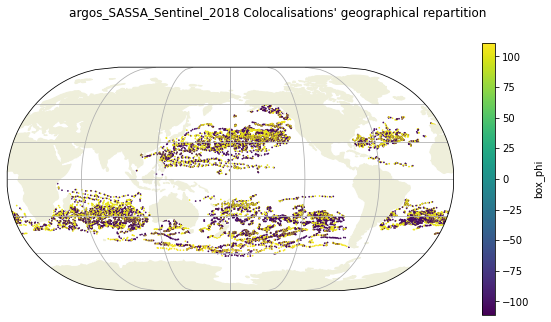

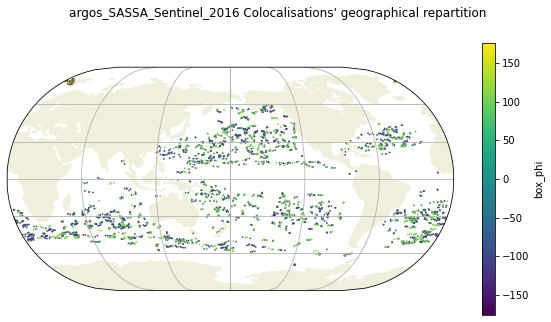

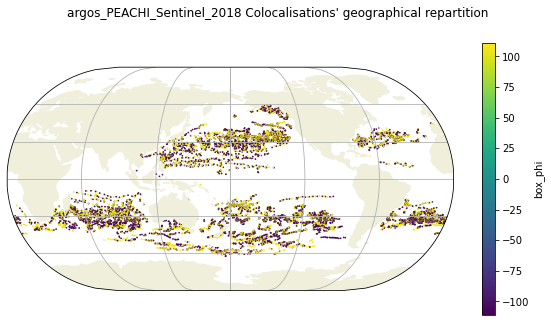

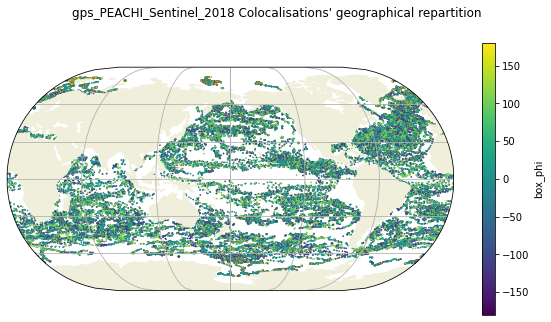

In [24]:
for key in DS:

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=-180))
    ax.add_feature(cfeature.LAND, zorder=2)
    gl = ax.gridlines()
    ax.set_extent([1e-4, -1e-4, -90, 90], ccrs.PlateCarree())
    DS[key].plot.scatter( x="lon", y="lat", hue='box_phi',cmap='viridis',s=0.5, ax=ax,transform=ccrs.PlateCarree())
    
    #ax.set_title(key,fontsize=15)

    fig.suptitle(f"{key} Colocalisations' geographical repartition")

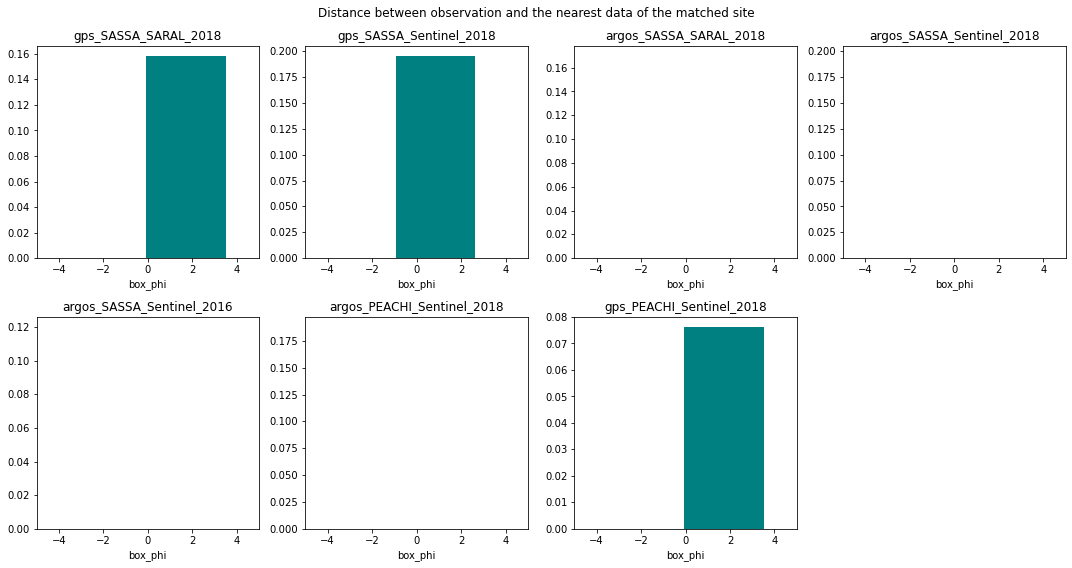

In [14]:
fig = plt.figure(figsize=(15,8))
j=0
for key in DS:
    ax = fig.add_subplot(2,4,j+1)
    DS[key]["box_phi"].plot.hist(bins=100, ax=ax,density=True, color='teal')
    ax.set_title(key)
    ax.set_xlim(-5,5)
    j+=1

fig.suptitle("Distance between observation and the nearest data of the matched site")
fig.tight_layout()

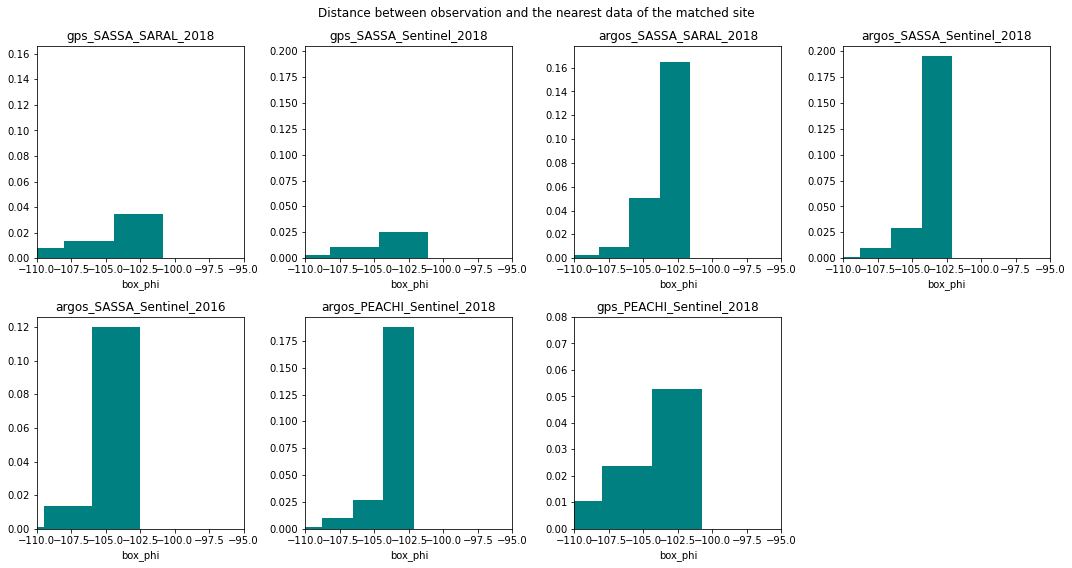

In [17]:
fig = plt.figure(figsize=(15,8))
j=0
for key in DS:
    ax = fig.add_subplot(2,4,j+1)
    DS[key]["box_phi"].plot.hist(bins=100, ax=ax,density=True, color='teal')
    ax.set_title(key)
    ax.set_xlim(-110,-95)
    j+=1

fig.suptitle("Distance between observation and the nearest data of the matched site")
fig.tight_layout()

In [5]:
cluster.close()